## 1. Elaboração do problema

O principal objetivo desse projeto é melhor entender o comportamento de clientes que fazem uso de um cartão de crédito e que apresentam ou não casos de inadimplência. Entender esse comportamento pode ajudar um banco, por exemplo, a identificar melhor os clientes que possuem risco de não efetuarem o pagamento da fatura do seu cartão de crédito.  
O estudo encontrado neste [link](https://www.sciencedirect.com/science/article/abs/pii/S0957417407006719) diz que, os banco emissores de cartão de crédito estavam enfrentando uma crise de caixa e dívidas de cartão de crédito e a inandimplência atingiu um valor alto no terceiro trimestre de 2006. Em busca de aumentar sua participação no mercados, os bancos acabaram por emitir cartões de crédito em excesso para diversos clientes que não são, de certa forma, "qualificados". 
Isso causou um consumo exacerbado desses cartões ao ponto de acumularem dívidas altissimas e consequentemente, não pagando-as.

Utilizando técnicas de _Machine Learning_ é possível encontrar um modelo que melhor faz a previsão de um cliente que pode ou não se tornar inadimplente, baseado nos dados históricos que se tem a respeito do mesmo. Atualmente é uma prática comum entre os bancos, desenvolverem ferramentas para melhor entender cada cliente. Compreender o padrão de consumo, renda, etc, ajuda a empresa a limitar ou até fornecer certo bônus para o mesmo, além de identificar previamente um possível inadimplente que está solicitando um determinado valor de crédito.

O _dataset_ utilizado para esse projeto está disponível no [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) e diz respeito a clientes de um banco em Taiwan, onde estão disponíveis diversas informações sobre eles, como o limite do cartão de crédito, quando as faturas dos últimos 6 meses foram pagas, quais foram essas faturas, de quanto foram os últimos pagamentos entre outros.

## 2. Importando as bibliotecas e carregando os dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
mpl.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("default of credit card clients.xls",
                  header=1)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 3. Análise inicial

O dataset que estamos trabalhando, empregou uma variável binária, o pagamento inadimplente, como sendo **1** para **SIM** e **0** para **NÃO**
- **ID**: Número de identificação atribuído a cada cliente
- **LIMIT_BAL**: Limite de Crédito
- **SEX**: Gênero
- **EDUCATION**: Nível de educação
- **MARRIAGE**: Estado civil
- **AGE**: Idade
- **PAY_**: Quando as últimas 6 contas foram pagas
- **BLL_AMT**: Quais foram as últimas 6 contas
- **PAY_AMT**: Quanto foram os úlitmos pagamentos
- **default payment next month**

De forma a facilitar o entendimento da nossa variável que iremos realizar a predição, vamos renomea-lá de **default payment next month** para apenas **DEFAULT**.

In [4]:
df.rename({'default payment next month': 'DEFAULT'}, axis = 'columns', 
          inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Neste problema não iremos fazer uso da coluna (_feature_) **ID**, por esse motivo vamos descartá-la.

In [5]:
df.drop('ID',axis=1,inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df.shape

(30000, 24)

Vamos identificar o tipo dos dados que estamos lidando até o momento no dataset. Pela célula executada abaixo, é possível ver que todas as _features_ do nosso dataset são do tipo _int64_, o que nos facilita em alguns aspectos por não precisarmos lidar com dados do tipo _string_ ou _object_.

In [7]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

Um breve resumo das estatísticas descritivas do nosso conjunto de dados está mostrado na célula logo abaixo.

In [8]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Podemos tirar algumas características dos nossos dados olhando para a tabela acima, como por exemplo:
- Dos clientes presentes no dataset, o mais novo apresenta a idade de 21 anos e o mais velho apresenta a idade de 79 anos.
- A média do limite do cartão de crédito dos clientes é de 167.484,32 dólares.

Vamos entender melhor o significado de cada uma das _features_ do dataset e quais valores (ou categorias) as mesmas podem tomar.

- **LIMIT_BAL**, a quantidade de crédito disponível **Inteiro**
- **SEX**: **Categórica**
    - 1 = Masculino
    - 2 = Feminino
- **EDUCATION**: **Categórica**
    - 1 = Pós-graduação
    - 2 = Universidade
    - 3 = Ensino médio
    - 4 = Outros
- **MARRIAGE**: **Categórica**
    - 1 = Casado
    - 2 = Solteiro
    - 3 = Outros
- **AGE**: **Inteiro**
- **PAY_**: quando as últimas 6 contas foram pagas **Categórica**
    - -1 = Paga no tempo certo
    - 1 = Pagamento atrasado em 1 mês
    - 2 = Pagamento atrasado em 2 meses
    - ...
    - 8 = Pagamento atrasado em 8 meses
    - 9 = Pagamento atrasdo em 9 meses ou mais
- **BLL_AMT**: quais foram as últimas 6 contas **Inteiro**
- **PAY_AMT**: de quanto foram os últimos pagamentos **Inteiro**
- **DEFAULT**
    - 0 = Não Inadimplente
    - 1 = Inadimplente

In [9]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [10]:
colunas = list(df.columns)
for col in colunas:
    print("{} : ".format(col))
    print(df[col].unique())

LIMIT_BAL : 
[  20000  120000   90000   50000  500000  100000  140000  200000  260000
  630000   70000  250000  320000  360000  180000  130000  450000   60000
  230000  160000  280000   10000   40000  210000  150000  380000  310000
  400000   80000  290000  340000  300000   30000  240000  470000  480000
  350000  330000  110000  420000  170000  370000  270000  220000  190000
  510000  460000  440000  410000  490000  390000  580000  600000  620000
  610000  700000  670000  680000  430000  550000  540000 1000000  530000
  710000  560000  520000  750000  640000   16000  570000  590000  660000
  720000  327680  740000  800000  760000  690000  650000  780000  730000]
SEX : 
[2 1]
EDUCATION : 
[2 1 3 5 4 6 0]
MARRIAGE : 
[1 2 3 0]
AGE : 
[24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]
PAY_0 : 
[ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_2 : 
[ 2  0 -1 -2  3  5  7  4  1  6  8

## 4. Análise Exploratória dos Dados

<Axes: xlabel='DEFAULT', ylabel='count'>

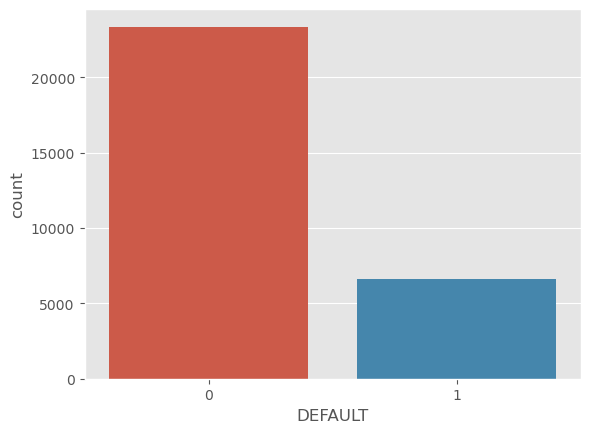

In [11]:
sns.countplot(x=df['DEFAULT'])

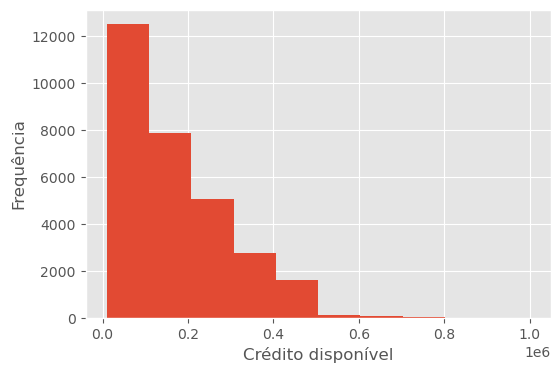

In [12]:
df['LIMIT_BAL'].plot(kind='hist',figsize=(6,4))
plt.xlabel('Crédito disponível')
plt.ylabel('Frequência')
plt.show()

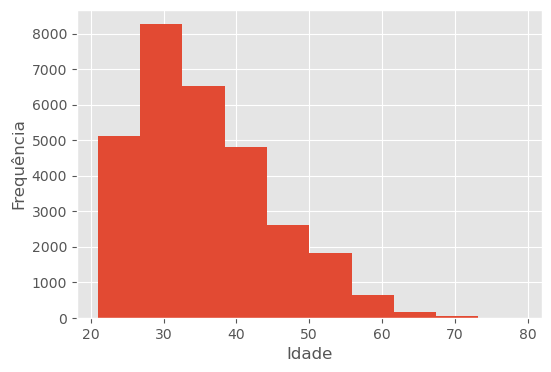

In [13]:
df['AGE'].plot(kind='hist',figsize=(6,4))
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

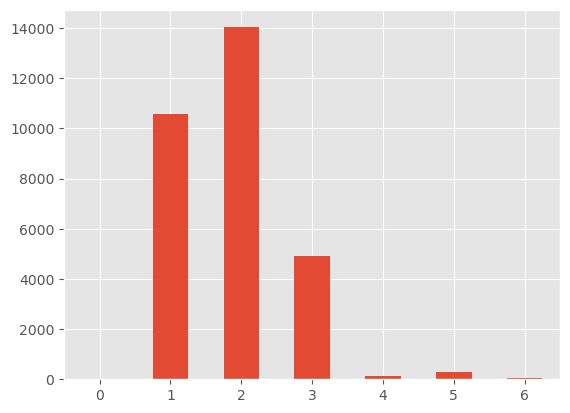

In [14]:
df['EDUCATION'].value_counts().sort_index().plot.bar(rot = 0, grid=True)
plt.show()

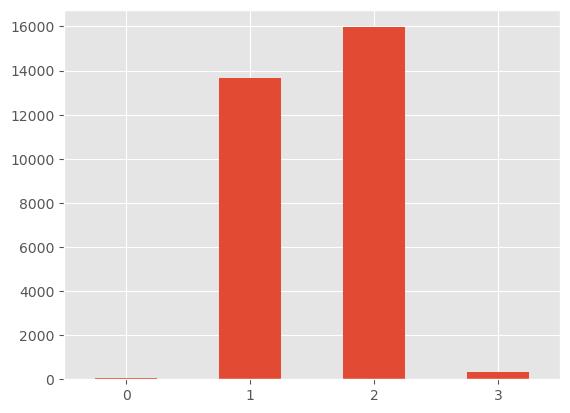

In [16]:
df['MARRIAGE'].value_counts().sort_index().plot.bar(rot = 0, grid=True)
plt.show()

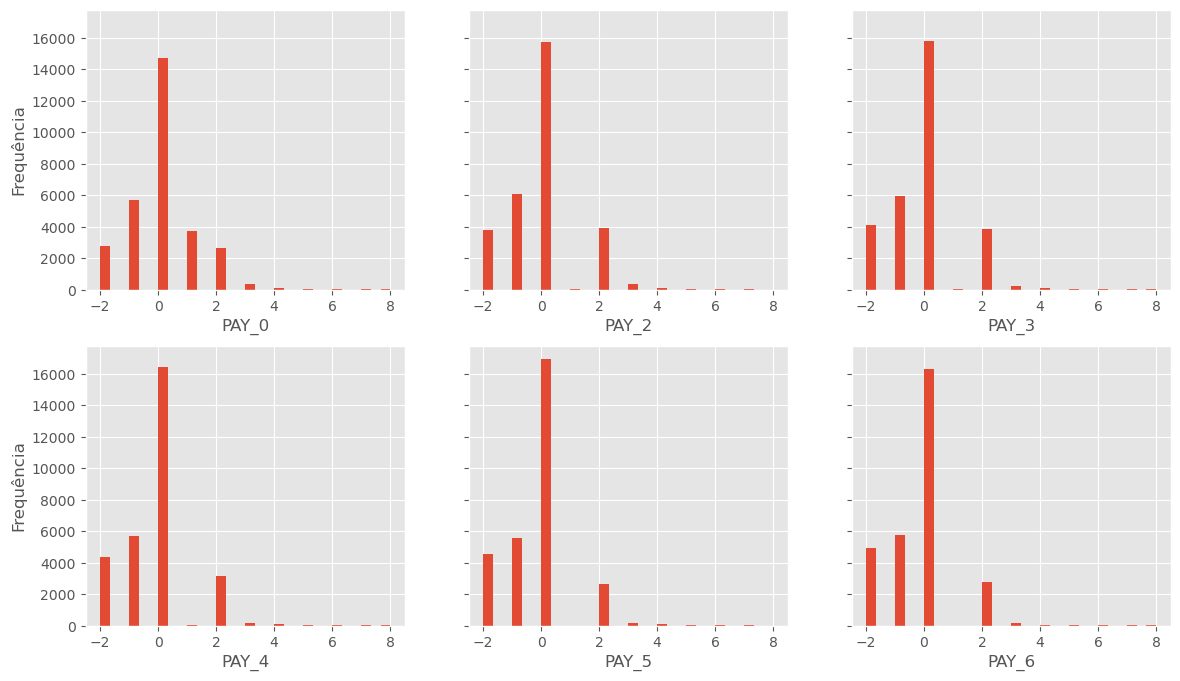

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8),
                         sharey=True)
pay = []
for i in range(5,11):
    pay.append(df.columns[i])
    
for i, n in enumerate(pay):
    plt.sca(axes[i//3, i %3])
    plt.hist(df[n], bins = 30)
    plt.xlabel(n)
    plt.ylabel("Frequência")
    if (i == 1) or (i == 2) or (i == 4) or (i == 5):
        plt.ylabel("")

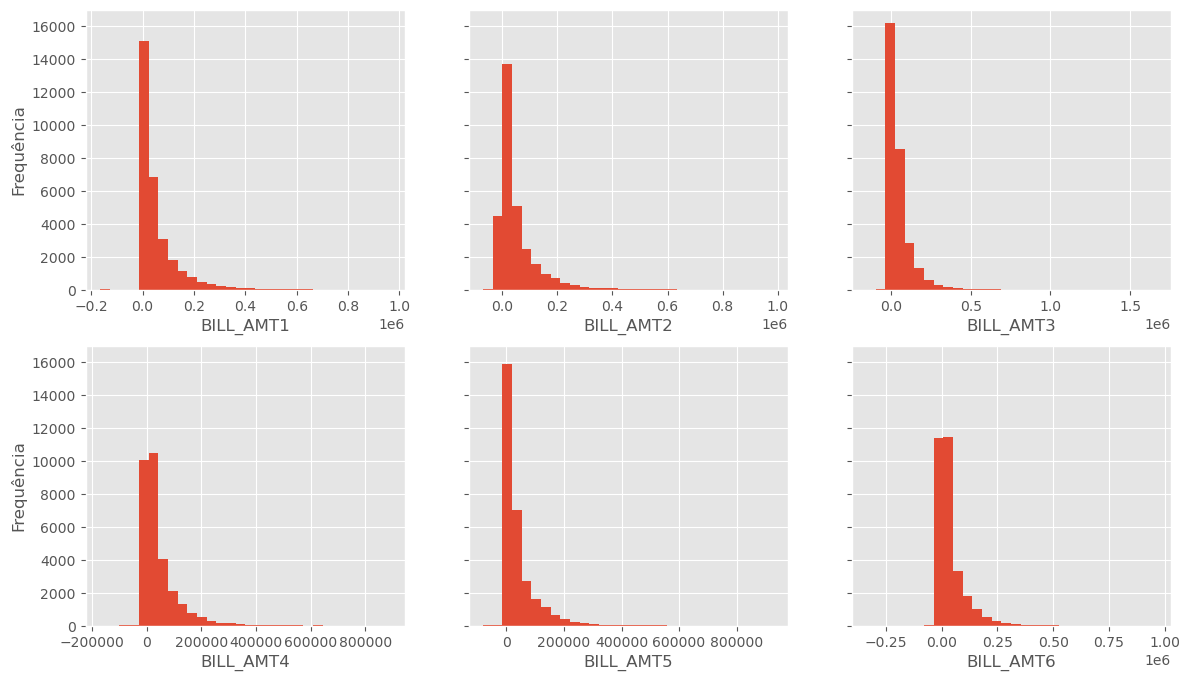

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8),
                         sharey=True)
bill_amt = []
for i in range(11,17):
    bill_amt.append(df.columns[i])
    
for i, n in enumerate(bill_amt):
    plt.sca(axes[i//3, i %3])
    plt.hist(df[n], bins = 30)
    plt.xlabel(n)
    plt.ylabel("Frequência")
    if (i == 1) or (i == 2) or (i == 4) or (i == 5):
        plt.ylabel("")

### 4.1 Correlações

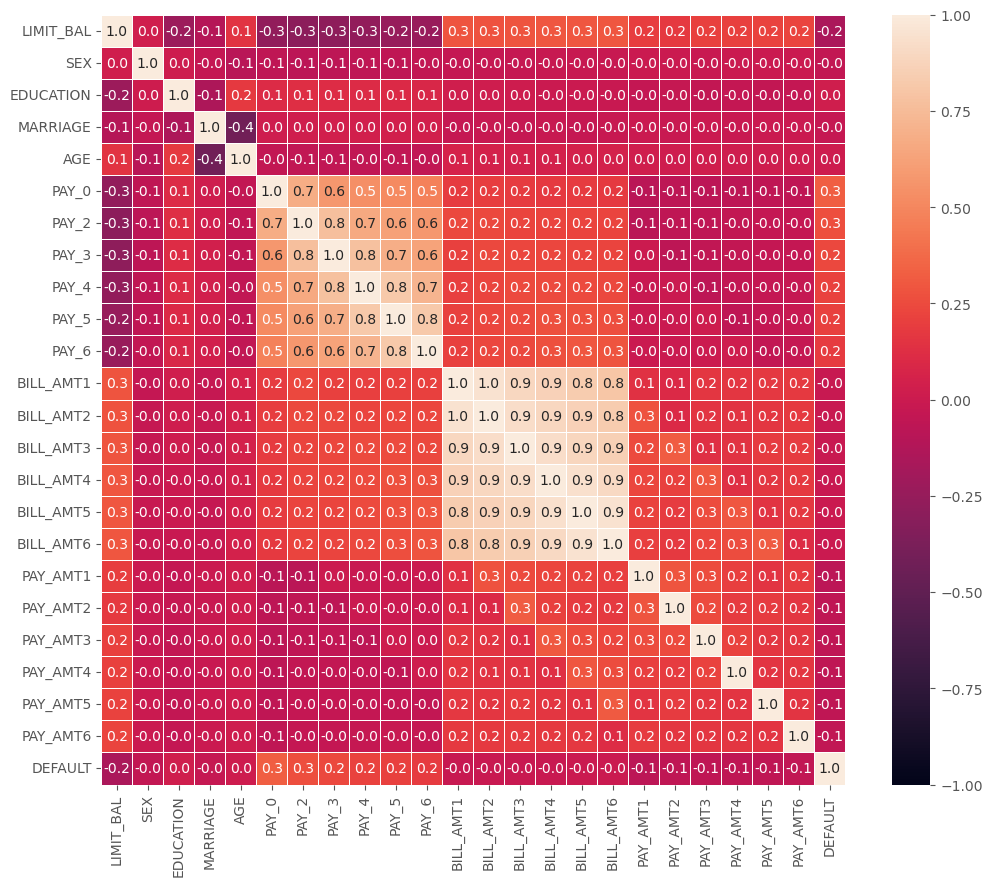

In [206]:
plt.figure(figsize=(12,10))
correlacao = df.corr()
sns.heatmap(correlacao, vmin = -1, vmax = 1,
           annot = True,
           fmt=".1f",
           linewidths=.4);

In [19]:
pagamento = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
montante_pag = ['BILL_AMT1','BILL_AMT2','BILL_AMT3',
                'BILL_AMT4','BILL_AMT5','BILL_AMT6']
valor_pago = ['PAY_AMT1','PAY_AMT2','PAY_AMT3',
              'PAY_AMT4','PAY_AMT5','PAY_AMT6']

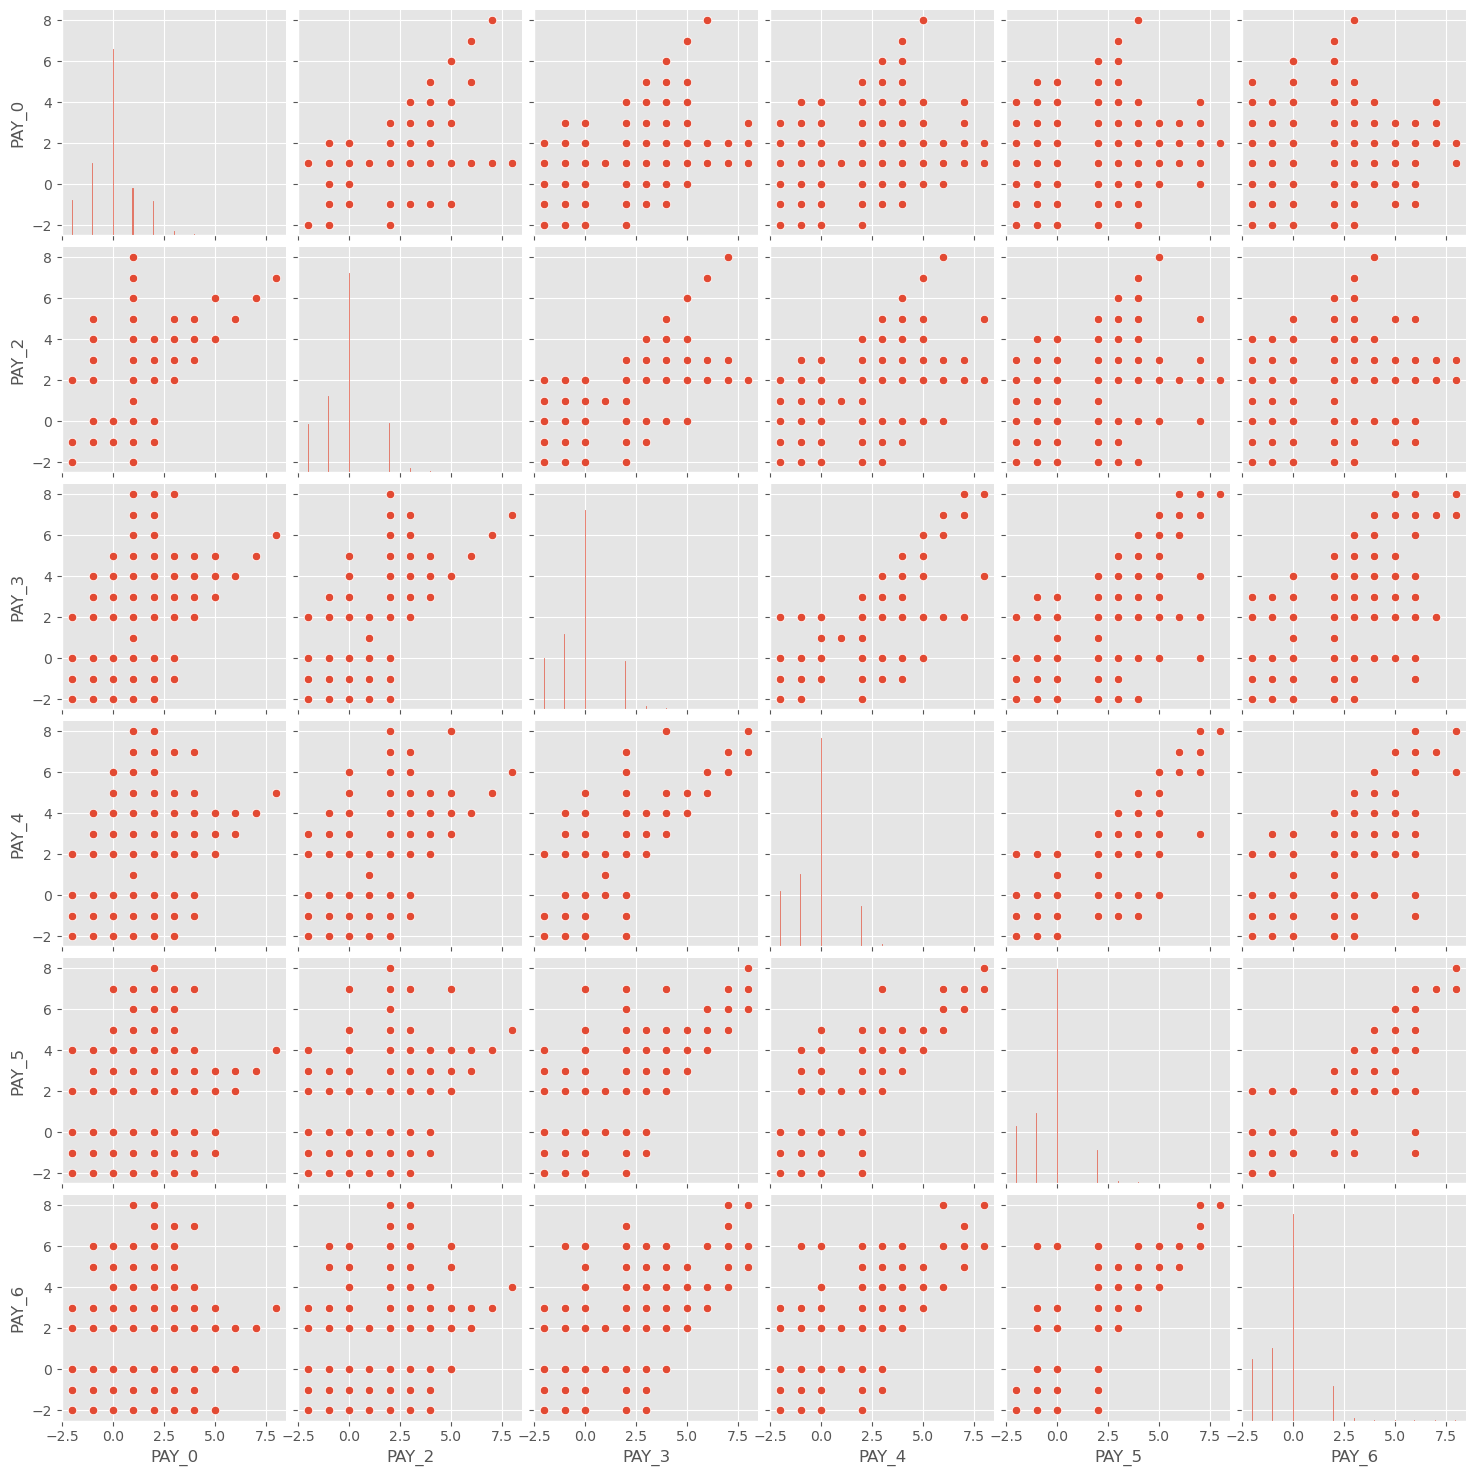

In [20]:
sns.pairplot(df[pagamento], vars = pagamento)
plt.show()

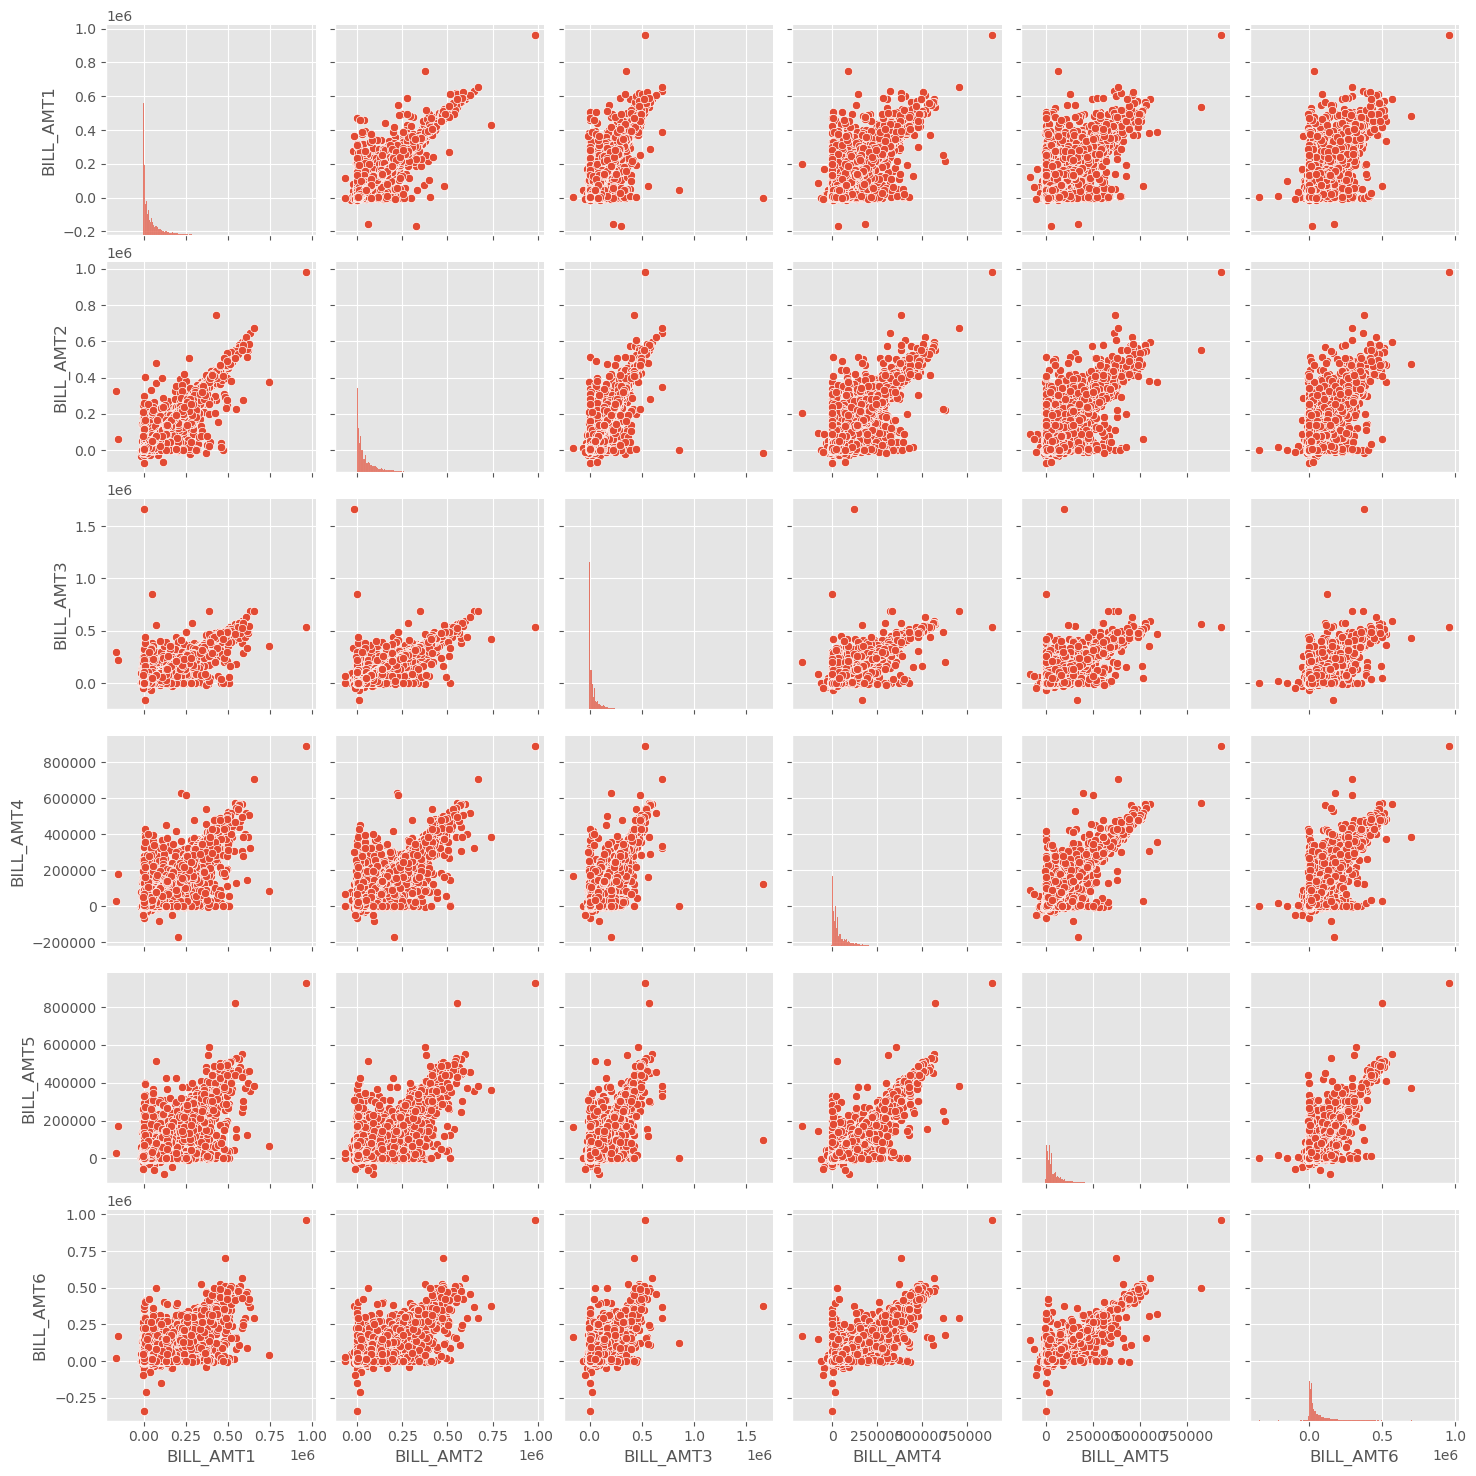

In [215]:
sns.pairplot(df[montante_pag], vars = montante_pag)
plt.show()

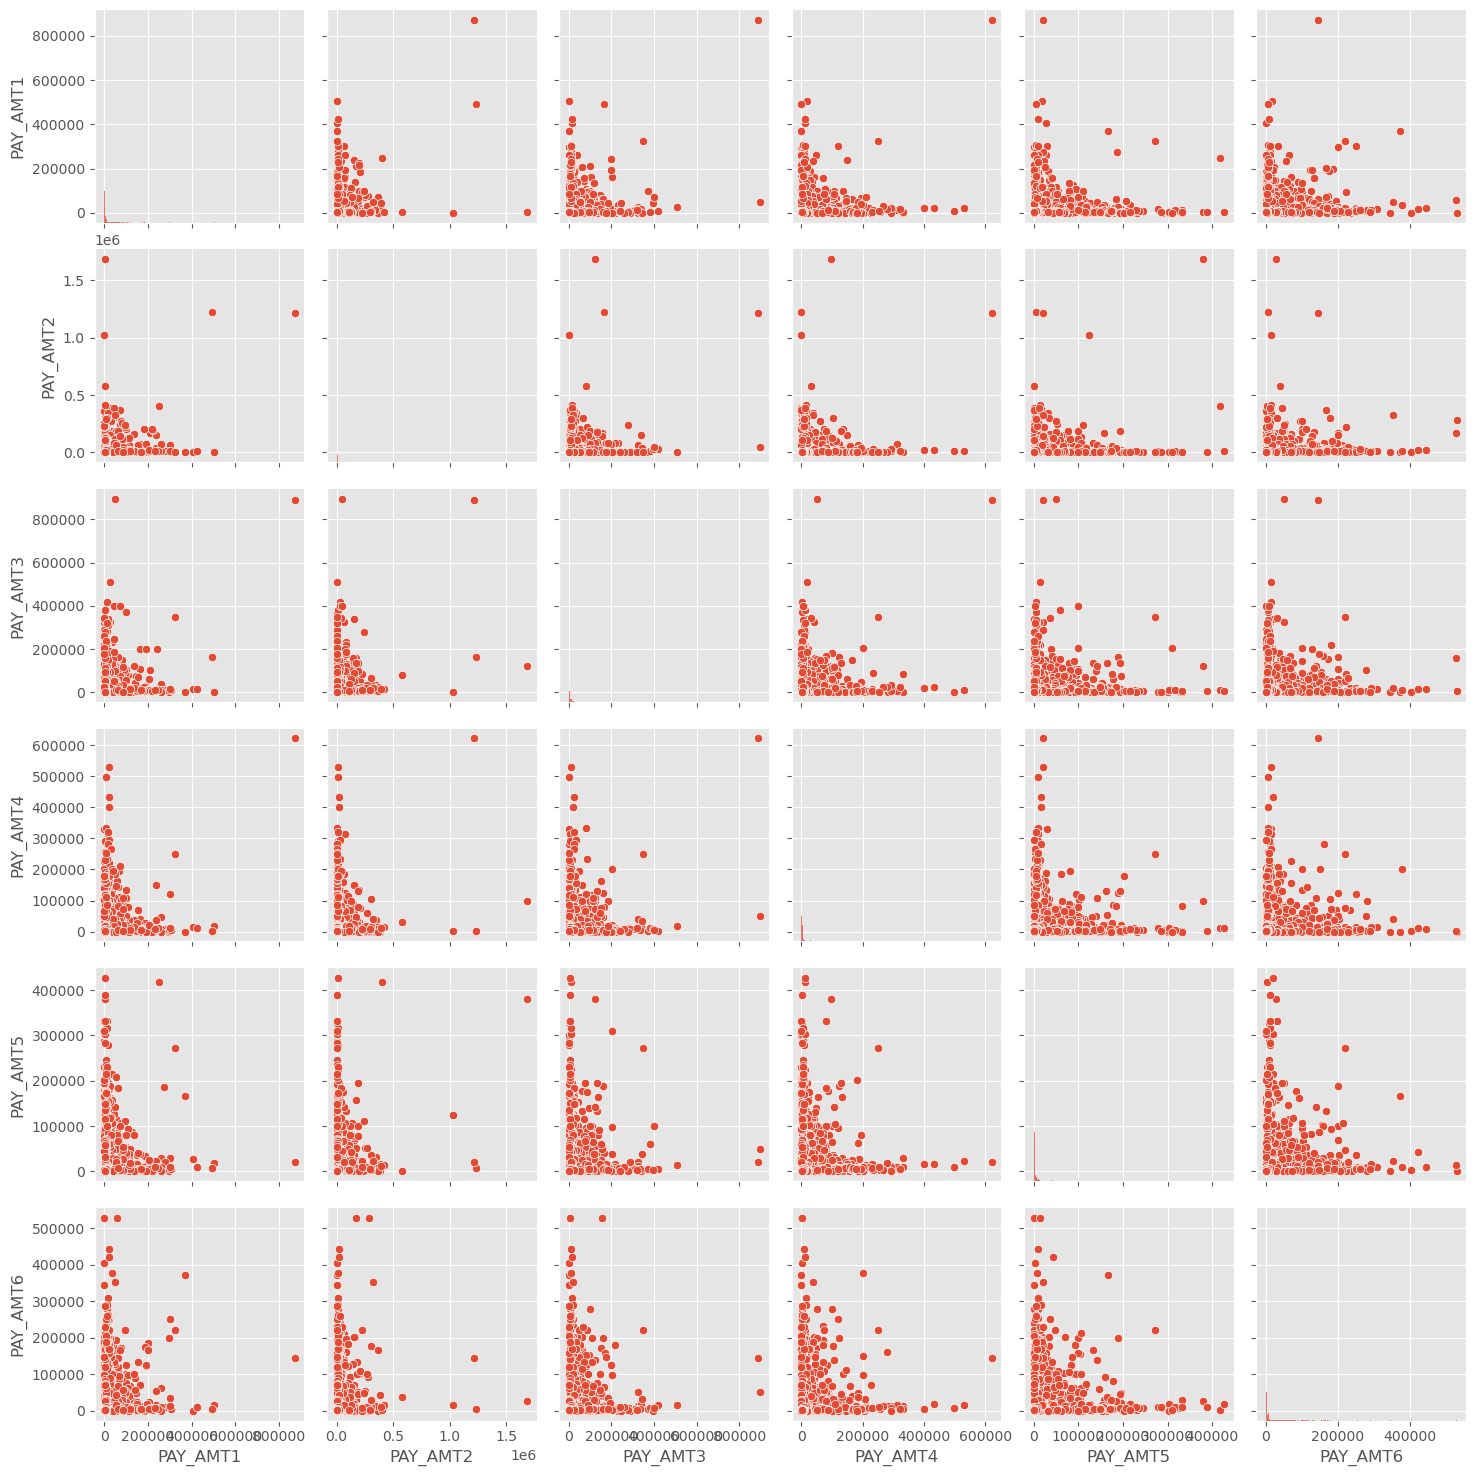

In [214]:
sns.pairplot(df[valor_pago], vars = valor_pago)
plt.show();

## 5. Pre-processamento dos dados

In [21]:
sim = df['DEFAULT'] == 1
nao = df['DEFAULT'] == 0
total = len(df['DEFAULT'])
proporcao_sim = sim.sum()/total
proporcao_nao = nao.sum()/total
print(f"Sim: {proporcao_sim:.2f} %")
print(f"Não: {proporcao_nao:.2f} %")

Sim: 0.22 %
Não: 0.78 %


In [22]:
df['SEX'].unique()

array([2, 1], dtype=int64)

In [23]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

In [24]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

In [25]:
len(df.loc[(df['EDUCATION']) == 0 | (df['MARRIAGE'] == 0)])

18

In [26]:
print("Porcentagem dos dados faltantes: ")
print(f"{(len(df.loc[(df['EDUCATION']) == 0 | (df['MARRIAGE'] == 0)])/len(df))*100} %")

Porcentagem dos dados faltantes: 
0.06 %


In [27]:
df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]

In [28]:
len(df_no_missing)

29932

### 5.1 Downsample dos dados

In [18]:
df_no_default = df_no_missing[df_no_missing['DEFAULT'] == 0]
df_default = df_no_missing[df_no_missing['DEFAULT'] == 1]

In [19]:
df_no_default_downsampled = resample(df_no_default,
                                    replace=False,
                                    n_samples=1000,
                                    random_state=42)
len(df_no_default_downsampled)

1000

In [20]:
df_default_downsampled = resample(df_default,
                                 replace=False,
                                 n_samples=1000,
                                 random_state=42)
len(df_default_downsampled)

1000

In [21]:
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsample)

2000

In [22]:
X = df_downsample.drop('DEFAULT', axis=1).copy()
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [23]:
y = df_downsample['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

In [24]:
X_encoded = pd.get_dummies(X, columns=['SEX',
                                      'EDUCATION',
                                      'MARRIAGE',
                                      'PAY_0',
                                      'PAY_2',
                                      'PAY_3',
                                      'PAY_4',
                                      'PAY_5',
                                      'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Construção de um modelo preliminar (Explorando o modelo de Support Vector Machines)

In [51]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

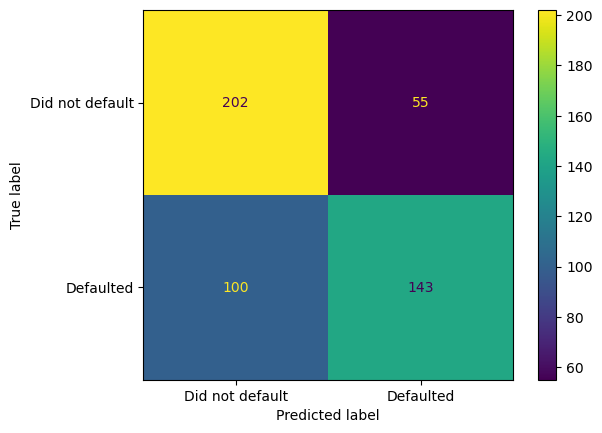

In [52]:
ConfusionMatrixDisplay.from_estimator(clf_svm,
                                     X_test_scaled,
                                     y_test,
                                     values_format='d',
                                     display_labels=['Did not default','Defaulted'])

In [53]:
y_pred = clf_svm.predict(X_test_scaled)

print("------ Métricas de desempenho nos dados de teste ------")
print(f"Acurácia: {accuracy_score(y_test,y_pred):.2f}")
print(f"Precisão: {precision_score(y_test,y_pred):.2f}")
print(f"Recall: {recall_score(y_test,y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test,y_pred):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test,y_pred):.2f}")

------ Métricas de desempenho nos dados de teste ------
Acurácia: 0.69
Precisão: 0.72
Recall: 0.59
F1 Score: 0.65
ROC-AUC: 0.69


### 6.1 Otimizando os parâmetros com GridSearchCV()

In [73]:
param_grid = [
    {'C': [0.5, 1, 10, 100],
    'gamma':['scale',1,0.1, 0.01, 0.001, 0.0001],
    'kernel':['rbf']}
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv = 5,
    scoring='accuracy',
    verbose=0)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [74]:
clf_svm = SVC(C=100 , gamma=0.001 , kernel = 'rbf')
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001)

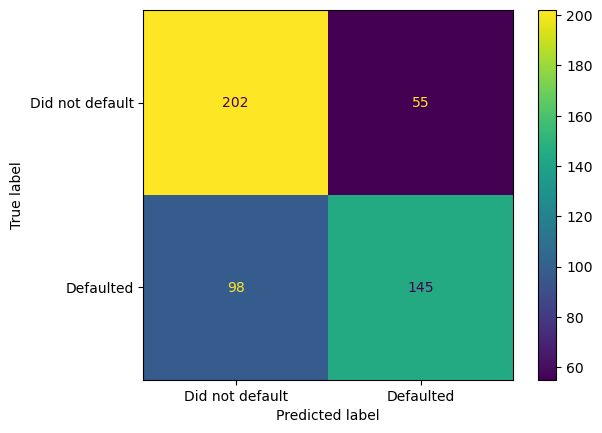

In [75]:
ConfusionMatrixDisplay.from_estimator(clf_svm,
                                     X_test_scaled,
                                     y_test,
                                     values_format='d',
                                     display_labels=['Did not default','Defaulted'])

In [76]:
y_pred_otimi = clf_svm.predict(X_test_scaled)

print("------ Métricas de desempenho nos dados de teste ------")
print(f"Acurácia: {accuracy_score(y_test,y_pred_otimi):.2f}")
print(f"Precisão: {precision_score(y_test,y_pred_otimi):.2f}")
print(f"Recall: {recall_score(y_test,y_pred_otimi):.2f}")
print(f"F1 Score: {f1_score(y_test,y_pred_otimi):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test,y_pred_otimi):.2f}")

------ Métricas de desempenho nos dados de teste ------
Acurácia: 0.69
Precisão: 0.72
Recall: 0.60
F1 Score: 0.65
ROC-AUC: 0.69


## 7. Aplicando diversos modelos

Undersampling do target usando `RandomUnderSampler()`

In [29]:
from imblearn.under_sampling import RandomUnderSampler

X = df_no_missing.drop('DEFAULT', axis=1).copy()
y = df_no_missing['DEFAULT'].copy()

rus = RandomUnderSampler(sampling_strategy='auto',
                        random_state=0)
X_resampled, y_resampled = rus.fit_resample(X,y)

In [30]:
numericas = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3',
            'BILL_AMT4','BILL_AMT5','BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2','PAY_AMT3',
            'PAY_AMT4','PAY_AMT5','PAY_AMT6']
categoricas = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0','PAY_2','PAY_3',
              'PAY_4','PAY_5','PAY_6']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                                    y_resampled,
                                                    random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X,
#                                                    y,
#                                                    random_state=42)

In [32]:
X_train.shape, X_test.shape

((9946, 23), (3316, 23))

In [33]:
y_train.shape, y_test.shape

((9946,), (3316,))

### 7.1 Combinação de diferentes features engineering

In [49]:
cat_transformer_OH = Pipeline(steps = [
    ('one hot enc', OneHotEncoder(categories='auto',handle_unknown = 'ignore'))
])

num_transformer_MM = Pipeline(steps = [
    ('min max scaler', MinMaxScaler())
])

num_transformer_SS = Pipeline(steps = [
    ('standard scaler', StandardScaler())
])

num_transformer_RS = Pipeline(steps = [
    ('robust scaler', RobustScaler())
])

# Preprocessing 1
# One Hot Encoder + Min Max Scaler
preprocessing_1 = ColumnTransformer(transformers = [
    ('cat', cat_transformer_OH, categoricas),
    ('num', num_transformer_MM, numericas)
])

# Preprocessing 2
# One Hot Encoder + Standard Scaler
preprocessing_2 = ColumnTransformer(transformers = [
    ('cat', cat_transformer_OH, categoricas),
    ('num', num_transformer_SS, numericas)
])

# Preprocessing 3
# One Hot Encoder + Robust Scaler
preprocessing_3 = ColumnTransformer(transformers = [
    ('cat', cat_transformer_OH, categoricas),
    ('num', num_transformer_RS, numericas)
])

# Preprocessing 4
# One Hot Encoder sem escalonamento 
preprocessing_4 = ColumnTransformer(transformers = [
    ('cat', cat_transformer_OH, categoricas)
])


preprocessing_list = [preprocessing_1, preprocessing_2,
                      preprocessing_3, preprocessing_4]

### 7.2 Modelos que serão avaliados

In [50]:
modelos = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          LogisticRegression(),
          KNeighborsClassifier()]

modelos_nomes = ['DecisionTreeClassifier',
                'RandomForestClassifier',
                'LogisticRegression',
                'KNeighborsClassifier']

for modelo in modelos:
    i = 1
    print(f"---- Métricas de desempenho - {modelo} ----")
    for preprocessing in preprocessing_list:
        pipe = Pipeline(steps = [('preprocessing',preprocessing),
                                ('modelos',modelo)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        print(f"-- preprocessing {i}")
        print(f"- Acurácia: {accuracy_score(y_test,y_pred):.2f}")
        print(f"- Precisão: {precision_score(y_test,y_pred):.2f}")
        print(f"- Recall: {recall_score(y_test,y_pred):.2f}")
        print(f"- F1 Score: {f1_score(y_test,y_pred):.2f}")
        print(f"- ROC-AUC: {roc_auc_score(y_test,y_pred):.2f}\n")
        i += 1

---- Métricas de desempenho - DecisionTreeClassifier() ----
-- preprocessing 1
- Acurácia: 0.63
- Precisão: 0.63
- Recall: 0.64
- F1 Score: 0.63
- ROC-AUC: 0.63

-- preprocessing 2
- Acurácia: 0.63
- Precisão: 0.63
- Recall: 0.64
- F1 Score: 0.64
- ROC-AUC: 0.63

-- preprocessing 3
- Acurácia: 0.64
- Precisão: 0.63
- Recall: 0.64
- F1 Score: 0.64
- ROC-AUC: 0.64

-- preprocessing 4
- Acurácia: 0.67
- Precisão: 0.72
- Recall: 0.56
- F1 Score: 0.63
- ROC-AUC: 0.67

---- Métricas de desempenho - RandomForestClassifier() ----
-- preprocessing 1
- Acurácia: 0.70
- Precisão: 0.72
- Recall: 0.65
- F1 Score: 0.68
- ROC-AUC: 0.70

-- preprocessing 2
- Acurácia: 0.70
- Precisão: 0.72
- Recall: 0.64
- F1 Score: 0.68
- ROC-AUC: 0.70

-- preprocessing 3
- Acurácia: 0.71
- Precisão: 0.74
- Recall: 0.65
- F1 Score: 0.69
- ROC-AUC: 0.71

-- preprocessing 4
- Acurácia: 0.69
- Precisão: 0.72
- Recall: 0.61
- F1 Score: 0.66
- ROC-AUC: 0.69

---- Métricas de desempenho - LogisticRegression() ----
-- prepr

Decistion Tree - preprocessing 3 (One Hot Encoder + Robust Scaler)

Random Forest - preprocessing 1 (One Hot Encoder + Min Max Scaler)

Logistic Regression - preprocessing 2 (One Hot Encoder + Standard Scaler)

KNeighborsClassifier - preprocessing 3 (One Hot Encoder + Robust Scaler)

### 7.3 Validação cruzada dos modelos

In [36]:
each_preprocessing = [preprocessing_3, 
                      preprocessing_1, 
                      preprocessing_2, 
                      preprocessing_3]

metrics_list = ['accuracy','precision','recall','f1','roc_auc']

cv = 10
modelos_dict = {}
i = 0
for modelo in modelos:
    pipe = Pipeline(steps = [('preprocessing',each_preprocessing[i]),
                            ('modelos', modelo)])
    metricas = cross_validate(pipe, X_train, y_train,
                             scoring=metrics_list, cv = cv)
    modelos_dict[modelos_nomes[i]] = {'acurácia':metricas['test_accuracy'],
                                     'precisão':metricas['test_precision'],
                                     'recall':metricas['test_recall'],
                                     'f1 score':metricas['test_f1'],
                                     'roc_auc':metricas['test_roc_auc']}
    i += 1

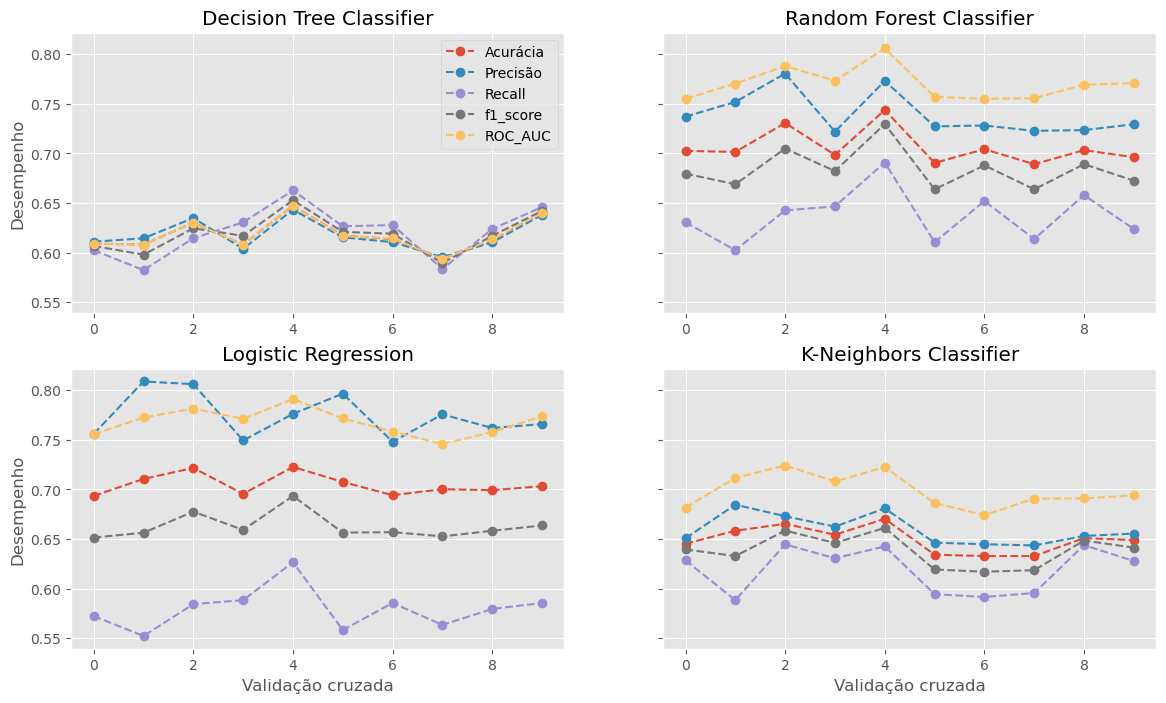

In [38]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,8), sharey=True)

plt.sca(axes[0,0])
plt.plot(range(cv), modelos_dict['DecisionTreeClassifier']['acurácia'],
        marker='o',linestyle='--',label='Acurácia')
plt.plot(range(cv), modelos_dict['DecisionTreeClassifier']['precisão'],
        marker='o',linestyle='--',label='Precisão')
plt.plot(range(cv), modelos_dict['DecisionTreeClassifier']['recall'],
        marker='o',linestyle='--',label='Recall')
plt.plot(range(cv), modelos_dict['DecisionTreeClassifier']['f1 score'],
        marker='o',linestyle='--',label='f1_score')
plt.plot(range(cv), modelos_dict['DecisionTreeClassifier']['roc_auc'],
        marker='o',linestyle='--',label='ROC_AUC')
plt.legend()
plt.ylabel("Desempenho")
plt.title('Decision Tree Classifier')

plt.sca(axes[0,1])
plt.plot(range(cv), modelos_dict['RandomForestClassifier']['acurácia'],
        marker='o',linestyle='--',label='Acurácia')
plt.plot(range(cv), modelos_dict['RandomForestClassifier']['precisão'],
        marker='o',linestyle='--',label='Precisão')
plt.plot(range(cv), modelos_dict['RandomForestClassifier']['recall'],
        marker='o',linestyle='--',label='Recall')
plt.plot(range(cv), modelos_dict['RandomForestClassifier']['f1 score'],
        marker='o',linestyle='--',label='f1_score')
plt.plot(range(cv), modelos_dict['RandomForestClassifier']['roc_auc'],
        marker='o',linestyle='--',label='ROC_AUC')
plt.title('Random Forest Classifier')

plt.sca(axes[1,0])
plt.plot(range(cv), modelos_dict['LogisticRegression']['acurácia'],
        marker='o',linestyle='--',label='Acurácia')
plt.plot(range(cv), modelos_dict['LogisticRegression']['precisão'],
        marker='o',linestyle='--',label='Precisão')
plt.plot(range(cv), modelos_dict['LogisticRegression']['recall'],
        marker='o',linestyle='--',label='Recall')
plt.plot(range(cv), modelos_dict['LogisticRegression']['f1 score'],
        marker='o',linestyle='--',label='f1_score')
plt.plot(range(cv), modelos_dict['LogisticRegression']['roc_auc'],
        marker='o',linestyle='--',label='ROC_AUC')
plt.ylabel('Desempenho')
plt.xlabel("Validação cruzada")
plt.title('Logistic Regression')

plt.sca(axes[1,1])
plt.plot(range(cv), modelos_dict['KNeighborsClassifier']['acurácia'],
        marker='o',linestyle='--',label='Acurácia')
plt.plot(range(cv), modelos_dict['KNeighborsClassifier']['precisão'],
        marker='o',linestyle='--',label='Precisão')
plt.plot(range(cv), modelos_dict['KNeighborsClassifier']['recall'],
        marker='o',linestyle='--',label='Recall')
plt.plot(range(cv), modelos_dict['KNeighborsClassifier']['f1 score'],
        marker='o',linestyle='--',label='f1_score')
plt.plot(range(cv), modelos_dict['KNeighborsClassifier']['roc_auc'],
        marker='o',linestyle='--',label='ROC_AUC')
plt.xlabel("Validação cruzada")
plt.title('K-Neighbors Classifier')
plt.show()

In [39]:
print("---- Valores médios para Decision Tree ----")
print(f"- Acurácia:\
      {modelos_dict['DecisionTreeClassifier']['acurácia'].mean():.2f}")
print(f"- Precisão:\
      {modelos_dict['DecisionTreeClassifier']['precisão'].mean():.2f}")
print(f"- Recall:\
      {modelos_dict['DecisionTreeClassifier']['recall'].mean():.2f}")
print(f"- F1 Score:\
      {modelos_dict['DecisionTreeClassifier']['f1 score'].mean():.2f}")
print(f"- ROC_AUC:\
      {modelos_dict['DecisionTreeClassifier']['roc_auc'].mean():.2f}\n")

print("---- Valores médios para Random Forest ----")
print(f"- Acurácia:\
      {modelos_dict['RandomForestClassifier']['acurácia'].mean():.2f}")
print(f"- Precisão:\
      {modelos_dict['RandomForestClassifier']['precisão'].mean():.2f}")
print(f"- Recall:\
      {modelos_dict['RandomForestClassifier']['recall'].mean():.2f}")
print(f"- F1 Score:\
      {modelos_dict['RandomForestClassifier']['f1 score'].mean():.2f}")
print(f"- ROC_AUC:\
      {modelos_dict['RandomForestClassifier']['roc_auc'].mean():.2f}\n")

print("---- Valores médios para Logistic Regression ----")
print(f"- Acurácia:\
      {modelos_dict['LogisticRegression']['acurácia'].mean():.2f}")
print(f"- Precisão:\
      {modelos_dict['LogisticRegression']['precisão'].mean():.2f}")
print(f"- Recall:\
      {modelos_dict['LogisticRegression']['recall'].mean():.2f}")
print(f"- F1 Score:\
      {modelos_dict['LogisticRegression']['f1 score'].mean():.2f}")
print(f"- ROC_AUC:\
      {modelos_dict['LogisticRegression']['roc_auc'].mean():.2f}\n")

print("---- Valores médios para K-Neigbhors ----")
print(f"- Acurácia:\
      {modelos_dict['KNeighborsClassifier']['acurácia'].mean():.2f}")
print(f"- Precisão:\
      {modelos_dict['KNeighborsClassifier']['precisão'].mean():.2f}")
print(f"- Recall:\
      {modelos_dict['KNeighborsClassifier']['recall'].mean():.2f}")
print(f"- F1 Score:\
      {modelos_dict['KNeighborsClassifier']['f1 score'].mean():.2f}")
print(f"- ROC_AUC:\
      {modelos_dict['KNeighborsClassifier']['roc_auc'].mean():.2f}\n")

---- Valores médios para Decision Tree ----
- Acurácia:      0.62
- Precisão:      0.62
- Recall:      0.62
- F1 Score:      0.62
- ROC_AUC:      0.62

---- Valores médios para Random Forest ----
- Acurácia:      0.71
- Precisão:      0.74
- Recall:      0.64
- F1 Score:      0.68
- ROC_AUC:      0.77

---- Valores médios para Logistic Regression ----
- Acurácia:      0.70
- Precisão:      0.77
- Recall:      0.58
- F1 Score:      0.66
- ROC_AUC:      0.77

---- Valores médios para K-Neigbhors ----
- Acurácia:      0.65
- Precisão:      0.66
- Recall:      0.62
- F1 Score:      0.64
- ROC_AUC:      0.70



## 8. Tunagem dos hiperparâmetros

### 8.1 Random Forest

In [40]:
# Pre-processamento utilizando a melhor combinação para a Random Forest
# One Hot Encoder + Min Max Scaler

ohe = OneHotEncoder(categories='auto', handle_unknown = 'ignore')
mm = MinMaxScaler()

train_ohe = ohe.fit_transform(X_train[categoricas]).toarray()
test_ohe = ohe.transform(X_test[categoricas]).toarray()

X_train_ohe = pd.DataFrame(train_ohe,
                          columns=ohe.get_feature_names_out(),
                          index=X_train[categoricas].index)
X_test_ohe = pd.DataFrame(test_ohe,
                         columns=ohe.get_feature_names_out(),
                         index=X_test[categoricas].index)
X_train_full = pd.concat([X_train[numericas], X_train_ohe], axis = 1)
X_test_full = pd.concat([X_test[numericas], X_test_ohe], axis = 1)

train_Scaled = mm.fit_transform(X_train_full)
test_Scaled = mm.transform(X_test_full)

X_train_Scaled = pd.DataFrame(train_Scaled,
                             columns = mm.get_feature_names_out(),
                             index = X_train_full.index)
X_test_Scaled = pd.DataFrame(test_Scaled,
                            columns = mm.get_feature_names_out(),
                            index = X_test_full.index)

In [631]:
#pipe_rf = Pipeline(steps = [('preprocessing',preprocessing_1),
#                           ('modelo_rf',RandomForestClassifier())])

#param_dist_rf = {'modelo_rf__max_depth':[3,None],
#                "modelo_rf__n_estimators":range(1,15),
#                "modelo_rf__max_features":np.linspace(1,50,1),
#                "modelo_rf__criterion":['gini','entropy']}

#model_rf_optim = GridSearchCV(pipe_rf, param_dist_rf, cv = 10, scoring='recall')
#model_rf_optim.fit(X_train, y_train)

param_dist_RF = {'max_depth':[3,None],
                'n_estimators':range(1,15),
                'max_features':np.linspace(1,50,1),
                'criterion':['gini','entropy']}

optimal_params_RF = GridSearchCV(RandomForestClassifier(),
                                param_dist_RF,
                                cv = 5,
                                scoring='recall')
optimal_params_RF.fit(X_train_Scaled, y_train)

print(f"Melhores parâmetros: {optimal_params_RF.best_params_}")
print(f"Melhor score: {optimal_params_RF.best_score_:.2f}")

Melhores parâmetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 1.0, 'n_estimators': 7}
Melhor score: 0.66


In [632]:
model_RF = RandomForestClassifier(max_depth = None, 
                                 n_estimators = 7,
                                 max_features = 1,
                                 criterion = 'gini')
model_RF.fit(X_train_Scaled, y_train)
y_pred_RF = model_RF.predict(X_test_Scaled)

print(f"- Acurácia: {accuracy_score(y_test,y_pred_RF):.2f}")
print(f"- Precisão: {precision_score(y_test,y_pred_RF):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_RF):.2f}")
print(f"- F1 Score: {f1_score(y_test,y_pred_RF):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test,y_pred_RF):.2f}\n")

- Acurácia: 0.67
- Precisão: 0.67
- Recall: 0.67
- F1 Score: 0.67
- ROC-AUC: 0.67



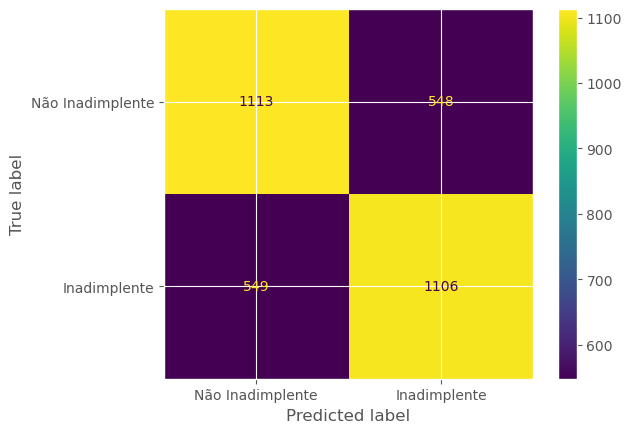

In [633]:
ConfusionMatrixDisplay.from_estimator(model_RF,
                                     X_test_Scaled,
                                     y_test,
                                     values_format='d',
                                     display_labels=['Não Inadimplente',
                                                     'Inadimplente'])

### 8.2 Logistic Regression

In [41]:
# Pre-processamento utilizando a melhor combinação para a Logistic Regression
# OneHotEncoder + Standard Scaler

ohe = OneHotEncoder(categories='auto', handle_unknown = 'ignore')
ss = StandardScaler()

train_ohe = ohe.fit_transform(X_train[categoricas]).toarray()
test_ohe = ohe.transform(X_test[categoricas]).toarray()

X_train_ohe = pd.DataFrame(train_ohe, 
                           columns=ohe.get_feature_names_out(),
                          index=X_train[categoricas].index)

X_test_ohe = pd.DataFrame(test_ohe,
                         columns=ohe.get_feature_names_out(),
                         index=X_test[categoricas].index)

X_train_full = pd.concat([X_train[numericas], X_train_ohe], axis = 1)
X_test_full = pd.concat([X_test[numericas], X_test_ohe], axis = 1)

train_scaled = ss.fit_transform(X_train_full)
test_scaled = ss.transform(X_test_full)

X_train_scaled = pd.DataFrame(train_scaled,
                             columns=ss.get_feature_names_out(),
                             index=X_train_full.index)

X_test_scaled = pd.DataFrame(test_scaled,
                            columns=ss.get_feature_names_out(),
                            index=X_test_full.index)

In [621]:
#pipe_lr = Pipeline(steps = [('preprocessing',preprocessing_2),
#                           ('modelo_lr',LogisticRegression())])

#param_dist_lr = {'modelo_lr__C':np.logspace(-5,8,20),
#                'modelo_lr__penalty':['l1','l2','elasticnet'],
#                'modelo_lr__max_iter':[100, 1000, 2500, 5000, 10000]}

#model_lr_optim = GridSearchCV(pipe_lr, param_dist_lr, cv=10, scoring='roc_auc')
#model_lr_optim.fit(X_train, y_train)
#print(f"Melhores parâmetros: {model_lr_optim.best_params_}")
#print(f"Melhor score: {model_lr_optim.best_score_:.2f}")

param_dist_LR = {'C':np.logspace(-5,8,20),
                'penalty':['l1','l2','elasticnet'],
                'max_iter':[100, 1000, 2500, 5000, 10000]}

optimal_params_LR = GridSearchCV(LogisticRegression(),
                                param_dist_LR,
                                cv = 5,
                                scoring='roc_auc')
optimal_params_LR.fit(X_train_scaled, y_train)
print(f"Melhores parâmetros: {optimal_params_LR.best_params_}")
print(f"Melhor score: {optimal_params_LR.best_score_:.2f}")



Melhores parâmetros: {'C': 0.0011288378916846896, 'max_iter': 100, 'penalty': 'l2'}
Melhor score: 0.77


In [622]:
#pipe_LR = Pipeline(steps = [('preprocessing',preprocessing_2),
#                            ('modelo',LogisticRegression(C=0.12742749857031346,
#                                                         max_iter=100,
#                                                         penalty='l2'))])
#pipe_LR.fit(X_train,y_train)
#y_pred_LR = pipe_LR.predict(X_test)

model_LR = LogisticRegression(C=0.0011288378916846896, 
                              max_iter=100, 
                              penalty='l2')
model_LR.fit(X_train_scaled, y_train)
y_pred_LR = model_LR.predict(X_test_scaled)

print(f"- Acurácia: {accuracy_score(y_test,y_pred_LR):.2f}")
print(f"- Precisão: {precision_score(y_test,y_pred_LR):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_LR):.2f}")
print(f"- F1 Score: {f1_score(y_test,y_pred_LR):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test,y_pred_LR):.2f}\n")

- Acurácia: 0.70
- Precisão: 0.77
- Recall: 0.58
- F1 Score: 0.66
- ROC-AUC: 0.70



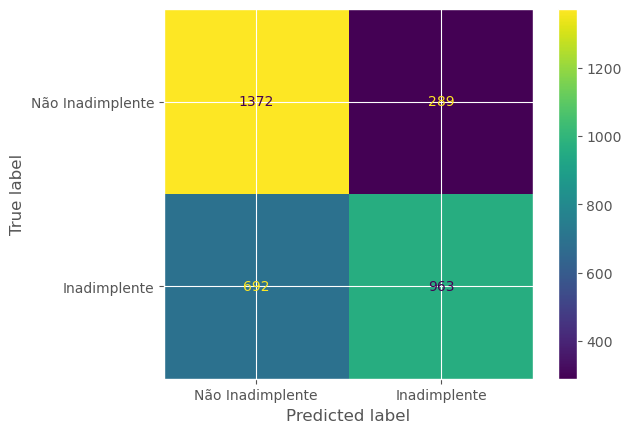

In [623]:
ConfusionMatrixDisplay.from_estimator(model_LR,
                                     X_test_scaled,
                                     y_test,
                                     values_format='d',
                                     display_labels=['Não Inadimplente',
                                                     'Inadimplente'])

### 8.3 ROC-AUC plot de ambos modelos

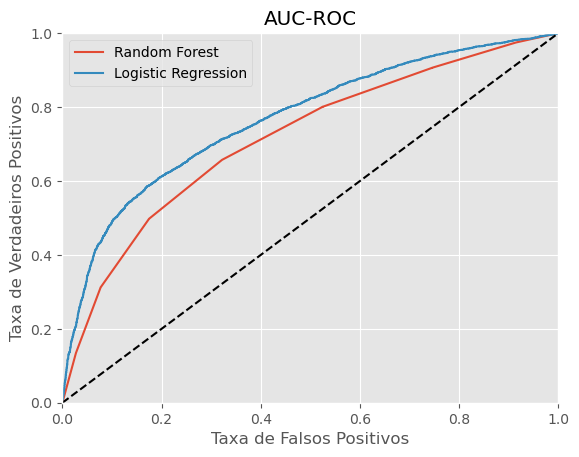

In [657]:
y_scores_rf = cross_val_predict(model_RF,
                               X_train_Scaled, y_train,
                               cv = 10,
                               method = 'predict_proba')
y_scores_rf = y_scores_rf[:,1]

y_scores_lr = cross_val_predict(model_LR,
                               X_train_scaled, y_train,
                               cv = 10,
                               method = 'predict_proba')
y_scores_lr = y_scores_lr[:,1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, y_scores_lr)

plt.plot(fpr_rf, tpr_rf, label = 'Random Forest')
plt.plot(fpr_lr, tpr_lr, label = 'Logistic Regression')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.axis([0,1,0,1])
plt.title('AUC-ROC')
plt.show()

## 9. Recursive Feature Elimination using Cross-Validation

### 9.1 RFECV para Random Forest

In [44]:
min_features_to_select = 5

rfecv_rf = RFECV(estimator = RandomForestClassifier(),
                step = 1,
                cv = 5,
                min_features_to_select = min_features_to_select)
rfecv_rf.fit(X_train_Scaled, y_train)

print(f"{rfecv_rf.n_features_}")
print(f"{rfecv_rf.support_}")

66
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False  True
  True  True  True False  True  True  True False False False  True  True
  True False  True  True  True  True False False False  True  True  True
 False  True  True  True False False  True  True  True  True  True  True
  True  True False False  True  True  True  True  True  True False False
 False False]


In [45]:
X_train_rf = rfecv_rf.fit_transform(X_train_Scaled, y_train)
X_test_rf = rfecv_rf.transform(X_test_Scaled)

In [51]:
model_rfecv_rf = RandomForestClassifier()
model_rfecv_rf.fit(X_train_rf, y_train)
y_pred_rfecv_rf = model_rfecv_rf.predict(X_test_rf)

print(f"- Acurácia: {accuracy_score(y_test,y_pred_rfecv_rf):.2f}")
print(f"- Precisão: {precision_score(y_test,y_pred_rfecv_rf):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_rfecv_rf):.2f}")
print(f"- F1 Score: {f1_score(y_test,y_pred_rfecv_rf):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test,y_pred_rfecv_rf):.2f}\n")

- Acurácia: 0.71
- Precisão: 0.73
- Recall: 0.65
- F1 Score: 0.69
- ROC-AUC: 0.71



### 9.2 GridSearch com as Features da RFECV pra Random Forest

In [60]:
param_dist_RF = {'max_depth':[3,None],
                'n_estimators':range(1,15),
                'max_features':np.linspace(1,50,1),
                'criterion':['gini','entropy']}

optimal_params_RF_RFECV = GridSearchCV(RandomForestClassifier(),
                                param_dist_RF,
                                cv = 5,
                                scoring='recall')
optimal_params_RF_RFECV.fit(X_train_rf, y_train)

print(f"Melhores parâmetros: {optimal_params_RF_RFECV.best_params_}")
print(f"Melhor score: {optimal_params_RF_RFECV.best_score_:.2f}")

Melhores parâmetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 1.0, 'n_estimators': 7}
Melhor score: 0.65


In [61]:
modelo_final_rf = RandomForestClassifier(n_estimators = 7,
                                        max_features = 1,
                                        max_depth = None,
                                        criterion = 'gini')
modelo_final_rf.fit(X_train_rf, y_train)
y_pred_final_rf = modelo_final_rf.predict(X_test_rf)

print(f"- Acurácia: {accuracy_score(y_test,y_pred_final_rf):.2f}")
print(f"- Precisão: {precision_score(y_test,y_pred_final_rf):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred_final_rf):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_final_rf):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_pred_final_rf):.2f}")

- Acurácia: 0.67
- Precisão: 0.67
- Recall: 0.67
- F1 Score: 0.67
- ROC-AUC: 0.67


### 9.3 RFECV para Logistic Regression

In [667]:
rfecv_lr = RFECV(estimator = LogisticRegression(),
                step = 1,
                cv = 5,
                min_features_to_select = min_features_to_select)
rfecv_lr.fit(X_train_scaled, y_train)
print(f"{rfecv_lr.n_features_}")
print(f"{rfecv_lr.support_}")

44
[ True False  True  True False  True  True False  True  True  True False
 False False False False False False False False  True False False  True
 False  True False  True  True  True  True  True False False  True  True
  True  True  True False False False  True False False  True False False
 False  True  True  True False  True  True  True  True False  True  True
 False  True False  True False  True  True False False False  True False
 False False  True  True  True False  True  True  True False False False
  True False]


In [670]:
X_train_lr = rfecv_lr.fit_transform(X_train_scaled, y_train)
X_test_lr = rfecv_lr.transform(X_test_scaled)

In [674]:
model_rfecv_lr = LogisticRegression()
model_rfecv_lr.fit(X_train_lr, y_train)
y_pred_rfecv_lr = model_rfecv_lr.predict(X_test_lr)

print(f"- Acurácia: {accuracy_score(y_test,y_pred_rfecv_lr):.2f}")
print(f"- Precisão: {precision_score(y_test,y_pred_rfecv_lr):.2f}")
print(f"- Recall: {recall_score(y_test,y_pred_rfecv_lr):.2f}")
print(f"- F1 Score: {f1_score(y_test,y_pred_rfecv_lr):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test,y_pred_rfecv_lr):.2f}\n")

- Acurácia: 0.71
- Precisão: 0.77
- Recall: 0.59
- F1 Score: 0.67
- ROC-AUC: 0.71



### 9.4 GridSearch com as features da RFECV para Logistic Regression

In [676]:
param_dist_LR = {'C':np.logspace(-5,8,20),
                'penalty':['l1','l2','elasticnet'],
                'max_iter':[100, 1000, 2500, 5000, 10000]}

optimal_params_LR_RFECV = GridSearchCV(LogisticRegression(),
                                param_dist_LR,
                                cv = 5,
                                scoring='recall')
optimal_params_LR_RFECV.fit(X_train_lr, y_train)
print(f"Melhores parâmetros: {optimal_params_LR_RFECV.best_params_}")
print(f"Melhor score: {optimal_params_LR_RFECV.best_score_:.2f}")

Melhores parâmetros: {'C': 0.00545559478116852, 'max_iter': 100, 'penalty': 'l2'}
Melhor score: 0.77
